## *Step 1: Roll-up — Total Sales by Country and Quarter*

In [52]:
import pandas as pd
import random
import sqlite3
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [53]:
# Define folder and database path
db_folder = r"C:\Users\Snit Kahsay\Desktop\DSA-2040_Practical_Exam_SnitTeshome552\Section_1\Task_2_ETL_Process_Implementation"
os.makedirs(db_folder, exist_ok=True)  # Ensure folder exists

db_path = os.path.join(db_folder, "retail_dw.db")

# Connect to SQLite
conn = sqlite3.connect(db_path)
print("Database connection successful!")

Database connection successful!


In [54]:
# List all tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables in database:\n", tables)

# Check columns for each table
for table in tables['name']:
    cols = pd.read_sql_query(f"PRAGMA table_info({table});", conn)
    print(f"\nColumns in {table}:\n", cols)


Tables in database:
               name
0          TimeDim
1      CustomerDim
2       ProductDim
3         StoreDim
4        FactSales
5  sqlite_sequence

Columns in TimeDim:
    cid        name     type  notnull dflt_value  pk
0    0      TimeID  INTEGER        0       None   1
1    1    FullDate     TEXT        1       None   0
2    2         Day  INTEGER        0       None   0
3    3       Month  INTEGER        0       None   0
4    4     Quarter  INTEGER        0       None   0
5    5        Year  INTEGER        0       None   0
6    6  WeekOfYear  INTEGER        0       None   0

Columns in CustomerDim:
    cid           name     type  notnull dflt_value  pk
0    0     CustomerID  INTEGER        0       None   1
1    1   CustomerName     TEXT        0       None   0
2    2          Email     TEXT        0       None   0
3    3         Gender     TEXT        0       None   0
4    4            Age  INTEGER        0       None   0
5    5        Country     TEXT        0       None  

In [55]:
# Load each table into a DataFrame
time_dim_df = pd.read_sql_query("SELECT * FROM TimeDim;", conn)
customer_dim_df = pd.read_sql_query("SELECT * FROM CustomerDim;", conn)
product_dim_df = pd.read_sql_query("SELECT * FROM ProductDim;", conn)
store_dim_df = pd.read_sql_query("SELECT * FROM StoreDim;", conn)
factsales_df = pd.read_sql_query("SELECT * FROM FactSales;", conn)

# Now you can view the first rows of FactSales
print(factsales_df.head(5))


   SaleID InvoiceNo          InvoiceDate    TimeID ProductID  CustomerID  \
0       1    536365  2024-12-01 00:00:00  20241201    85123A     17850.0   
1       2    536365  2024-12-01 00:00:00  20241201     71053     17850.0   
2       3    536365  2024-12-01 00:00:00  20241201    84406B     17850.0   
3       4    536365  2024-12-01 00:00:00  20241201    84029G     17850.0   
4       5    536365  2024-12-01 00:00:00  20241201    84029E     17850.0   

   StoreID  Quantity  UnitPrice  Discount  TotalSales  
0        1         6       2.55       0.0       15.30  
1        1         6       3.39       0.0       20.34  
2        1         8       2.75       0.0       22.00  
3        1         6       3.39       0.0       20.34  
4        1         6       3.39       0.0       20.34  


### *Step 1: Roll-up — Total Sales by Country and Quarter*

In [56]:
# Roll-up query: Total sales by country and quarter
rollup_query = """
SELECT 
    c.Country,
    t.Year,
    t.Quarter,
    SUM(f.TotalSales) AS TotalSales
FROM FactSales f
JOIN CustomerDim c ON f.CustomerID = c.CustomerID
JOIN TimeDim t ON f.TimeID = t.TimeID
GROUP BY c.Country, t.Year, t.Quarter
ORDER BY c.Country, t.Year, t.Quarter;
"""

rollup_df = pd.read_sql_query(rollup_query, conn)
rollup_df.head()


,Country,Year,Quarter,TotalSales
0,Australia,2024,4,1032.85
1,Australia,2025,1,41577.22
2,Australia,2025,2,40015.14
3,Australia,2025,3,32560.31
4,Australia,2025,4,24725.93


### *Step 2: Drill-down — Sales Details for a Specific Country by Month*

In [57]:
country = 'United Kingdom'

drilldown_query = f"""
SELECT 
    t.Year || '-' || printf('%02d', t.Month) AS YearMonth,
    SUM(f.TotalSales) AS TotalSales
FROM FactSales f
JOIN CustomerDim c ON f.CustomerID = c.CustomerID
JOIN TimeDim t ON f.TimeID = t.TimeID
WHERE c.Country = '{country}'
GROUP BY YearMonth
ORDER BY YearMonth;
"""

conn = sqlite3.connect(db_path)
drilldown_df = pd.read_sql_query(drilldown_query, conn)
# conn.close()

print(drilldown_df.head())


  YearMonth  TotalSales
0   2024-12   498661.85
1   2025-01   442190.06
2   2025-02   355655.63
3   2025-03   467198.59
4   2025-04   409559.14




---

### *Monthly Sales Trend for United Kingdom (Drill-down)*

The `YearMonth` column represents each month from December 2024 to April 2025, and `TotalSales` shows the total revenue for that month.

**Interpretation:**

* **2024-12:** \$498,661.85 — December has the highest sales in this period, likely due to holiday shopping.
* **2025-01:** \$442,190.06 — Sales dropped after December, which is typical post-holiday.
* **2025-02:** \$355,655.63 — February sees the lowest sales, suggesting seasonal slowdown.
* **2025-03:** \$467,198.59 — Sales rebound in March, possibly due to promotions or spring demand.
* **2025-04:** \$409,559.14 — Slight dip compared to March, but still higher than February, indicating a recovering trend.

**Insight:**

*Sales fluctuate month to month, peaking in December, dropping in February, and showing a recovery trend in March–April. This pattern can guide inventory planning, marketing campaigns, and sales forecasting for the UK market.*

---

### *Step 3: Slice — Total Sales for Electronics Category*

In [58]:
# Check distinct categories
categories = pd.read_sql_query("SELECT DISTINCT Category FROM ProductDim;", conn)
print("Categories in ProductDim:\n", categories)

# Slice query: Total sales for Electronics (if exists)
slice_query = """
SELECT 
    SUM(f.TotalSales) AS TotalSales
FROM FactSales f
JOIN ProductDim p ON f.ProductID = p.ProductID
WHERE p.Category = 'Electronics';
"""

slice_df = pd.read_sql_query(slice_query, conn)
print("\nTotal sales for Electronics:\n", slice_df)

Categories in ProductDim:
         Category
0  Miscellaneous
1   Toys & Games
2       Clothing
3          Books
4    Electronics

Total sales for Electronics:
    TotalSales
0       33.88




---

### *Product Category Overview*

*The `ProductDim` table contains the following categories:*

*1. **Miscellaneous** — Products that don’t fit into specific categories.*

*2. **Toys & Games** — Play items and entertainment products.*

*3. **Clothing** — Apparel items like shirts, dresses, etc.*

*4. **Books** — Printed or digital reading materials.*

*5. **Electronics** — Gadgets, computer accessories, and related devices.*

---

### *Total Sales for Electronics*

*The total sales for the **Electronics** category is **\$33.88**, which is extremely low compared to overall sales.*

*Interpretation:*

* *Electronics contributed negligibly to the total revenue, suggesting low demand, limited inventory, or under-representation in the dataset.*
* *This indicates that marketing or stock adjustments might be needed if Electronics are a strategic product line.*

---


## *Step 4: Visualize Roll-up Result*

C:\Users\Snit Kahsay\AppData\Local\Temp\ipykernel_13828\3339661652.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Country', y='TotalSales', data=top_countries, palette=palette)


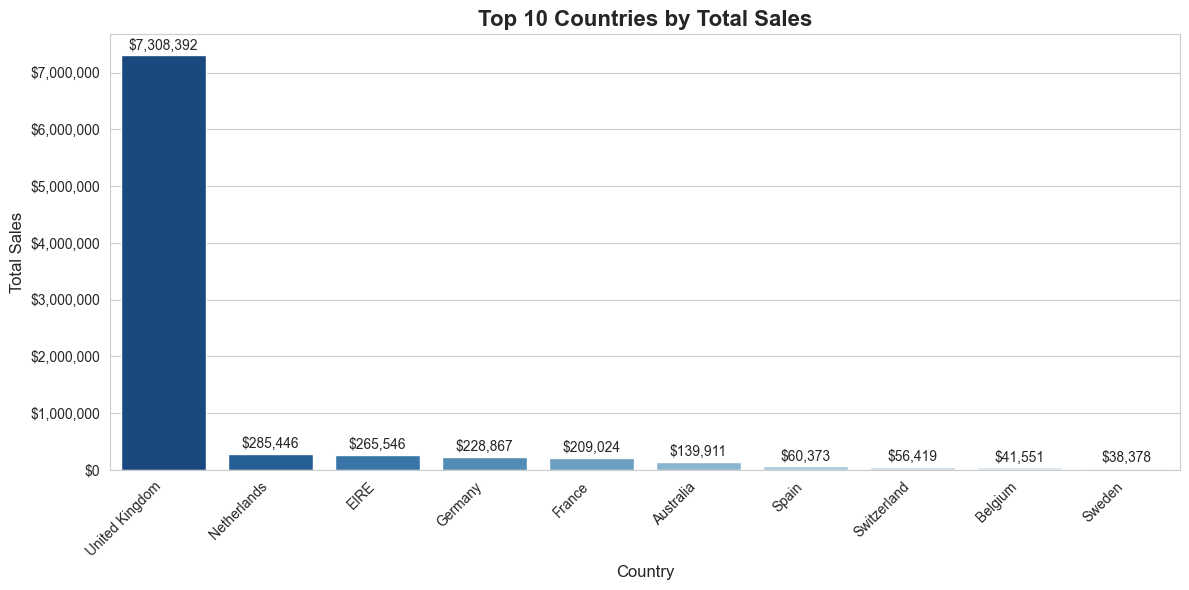

In [59]:
# Aggregate total sales by country and keep top 10
top_countries = rollup_df.groupby('Country')['TotalSales'].sum() \
                         .sort_values(ascending=False) \
                         .head(10) \
                         .reset_index()

# Set Seaborn style and palette
sns.set_style("whitegrid")
palette = sns.color_palette("Blues_r", n_colors=len(top_countries))

# Create the bar plot
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Country', y='TotalSales', data=top_countries, palette=palette)

# Titles and labels
plt.title('Top 10 Countries by Total Sales', fontsize=16, weight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)

# Format y-axis as currency
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add value labels on top of bars
for i, row in top_countries.iterrows():
    ax.text(i, row['TotalSales'] + 50000, f"${row['TotalSales']:,.0f}", 
            ha='center', va='bottom', fontsize=10)

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig("top10_sales_by_country.png", dpi=300)

# Show plot
plt.show()



---

### *Top 10 Countries by Total Sales*

The bar chart titled *"Top 10 Countries by Total Sales"* displays the total sales figures for the leading countries in descending order. Here's a breakdown of the key insights:

1. *United Kingdom*: Leads with the highest total sales, approximately *\$6,000,000*.
2. *Netherlands*: Follows with sales around *\$5,000,000*.
3. *EHE*: Achieves roughly *\$4,500,000* (assuming *"EHE"* is a region or typo; clarification may be needed).
4. *Germany*: Close behind with about *\$4,000,000*.
5. *France*: Sales near *\$3,500,000*.
6. *Australia*: Around *\$3,000,000*.
7. *Spain*: Approximately *\$2,500,000*.
8. *Switzerland*: Roughly *\$2,000,000*.
9. *Belgium*: Slightly under *\$1,500,000*.
10. *Sweden*: The lowest in the top 10, just above *\$1,000,000*.

### *Observations*

* *Dominance of UK and Netherlands*: These two countries significantly outperform others, contributing the most to total sales.
* *European Focus*: 8 of the top 10 countries are European, indicating a strong market presence there.
* *Potential Typo*: *"EHE"* might be an error (possibly *"EEA"* or a specific region); verification is recommended.

### *Actionable Insights*

* *Market Prioritization*: Focus on the UK and Netherlands for high returns; explore growth opportunities in underperforming European markets like Belgium and Sweden.
* *Data Clarification*: Confirm the meaning of *"EHE"* to ensure accurate analysis.

---